<a href="https://colab.research.google.com/github/MMoronto/ml-unstructured-data-projects/blob/master/Tile_based_classification_using_Sentinel_2_and_EuroSAT_data_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Intro**

This workflow explores the process of training a `Convolutional Neural Network (CNN)` with Keras based on the benchmark dataset EuroSAT. This noote book contains notes I've taken as I work through the example workflow presented in the AI for Earth monitoring MOOC on Futurelearn.


##**Machine-Learning Algorithm**

This example develops a `Sequential Convolutional Neural Network (CNN)` with TF Keras.

##**Data**
The model is trained on the EuroSAT benchmark dataset which is based on Sentinel-2 satellite images and consists of 27,000 labeled and geo-referenced images.The dataset provides information on the following ten land cover/land use cases:
* `Annual Crop`
* `Forest`
* `Herbaceous Vegetation`
* `Highway`
* Industrial`
* `Pasture`
* `Permanent Crop`
* `Residential`
* `River`
* `Sea Lake`

The benchmark dataset can be used to detect `land cover / land use changes`. The geo-referenced datasset EuroSAT is publicly accessible here: https://github.com/phelber/eurosat

## Notebook Outline
* 1 - Load the EuroSAT benchmark dataset as input data
* 2 - Create training and test subsets from input data
* 3 - Define the Convolutional Neural Network architecture
* 4 - Fit (train) the convolutional neural network (CNN)
* 5 - Evaluate the performance of the CNN model with a confusion matrix


**Import Libraries**

In [51]:
## Begin S3FS Import Snippet ##
import os, sys
s3_home = os.getcwd()
try: sys.path.remove(s3_home) # Remove the S3 from the $path
except Exception: pass

# current_dir = os.getcwd()

# os.chdir('/home/jovyan') # Temporarily move to another directory

# Begin imports #
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from osgeo import gdal_array
from matplotlib import pyplot as pyplot
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import zipfile
# end imports #

# os.chdir(current_dir) # go back to your previous dir

# sys.path.append(s3_home) # restore the s3 root in the $path

## end s3fs import snippet ##



In [4]:
# !unzip "drive/MyDrive/Land Classification/S2_Tile_based_classification.zip" -d "drive/MyDrive/Land Classification/"

Define helper functions

from_folder_to_stack

In [5]:
import numpy as np

'''
function name:
  from_folder_to_stack
description:
  This function transforms the .SAFE file into three different arrays (10m, 20m and 60m).
Input:
  safe_path: the path of the .SAFE file;
  data_bands_20m: if True, the fumnction computes stack using Sentinel2 band with 20m of pixel resolution (default=True);
  data_bands_60m: if True, the function computes stack using Sentinel2 band with 60m of pixel resolution (default=True);
Output:
  stack_10m: stack with the following S2L1C bands (B02, B03, B04, B08)
  stack_20m: stack with the following S2L1C bands (B05, B06, B07, B11, B12, B8A)
  stack_60m: stack with the following S2L1C bands (B01, mB09, B10)
'''
def from_folder_to_stack(
    safe_path,
    data_bands_20m=True,
    data_bands_60m=True,
    ):

  level_folder_name_list = glob.glob(safe_path + 'GRANULE/*')
  level_folder_name = level_folder_name_list[0]

  if level_folder_name.find("L2A") < 0:
    safe_path = [level_folder_name + '/IMG_DATA/']
  else:
    safe_path_10m = level_folder_name + '/IMG_DATA/R10m/'
    safe_path = [safe_path_10m]

  text_files = []

  for i in range(0, len(safe_path)):
      print("[AI4EO_MOOC]_log: Loading .jp2 images in %s" % (safe_path[i]))
      text_files_tmp = [f for f in os.listdir(safe_path[i]) if f.endswith('.jp2')]
      text_files.append(text_files_tmp)

  lst_stack_60m=[]
  lst_code_60m=[]
  lst_stack_20m=[]
  lst_code_20m=[]
  lst_stack_10m=[]
  lst_code_10m=[]
  for i in range(0, len(safe_path)):

    print("[AI4EO_MOOC]_log: Reading .jp2 files in %s" % (safe_path[i]))
    for name in range(0, len(text_files[i])):
      text_files_tmp = text_files[i]
      if data_bands_60m == True:
        cond_60m = ( (text_files_tmp[name].find("B01") > 0) or (text_files_tmp[name].find("B09") > 0)
                    or (text_files_tmp[name].find("B10") > 0))
        if cond_60m:
            print("[AI4EO_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
            lst_stack_60m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
            lst_code_60m.append(text_files_tmp[name][24:26])

      if data_bands_20m == True:
          cond_20m = (text_files_tmp[name].find("B05") > 0) or (text_files_tmp[name].find("B06") > 0) or (
                      text_files_tmp[name].find("B07") > 0) or (text_files_tmp[name].find("B11") > 0) or (
                                  text_files_tmp[name].find("B12") > 0) or (text_files_tmp[name].find("B8A") > 0)
          cond_60m_L2 = (text_files_tmp[name].find("B05_60m") < 0) and (text_files_tmp[name].find("B06_60m") < 0) and (
                      text_files_tmp[name].find("B07_60m") < 0) and (text_files_tmp[name].find("B11_60m") < 0) and (
                                  text_files_tmp[name].find("B12_60m") < 0) and (text_files_tmp[name].find("B8A_60m") < 0)
          cond_20m_tot = cond_20m and cond_60m_L2
          if cond_20m_tot:
              print("[AI4E_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
              lst_stack_20m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
              lst_code_20m.append(text_files_tmp[name][24:26])
      else:
        stack_20m = 0

      cond_10m = (text_files_tmp[name].find("B02") > 0) or (text_files_tmp[name].find("B03") > 0) or (
                  text_files_tmp[name].find("B04") > 0) or (text_files_tmp[name].find("B08") > 0)
      cond_20m_L2 = (text_files_tmp[name].find("B02_20m") < 0) and (text_files_tmp[name].find("B03_20m") < 0) and (
                  text_files_tmp[name].find("B04_20m") < 0) and (text_files_tmp[name].find("B08_20m") < 0)
      cond_60m_L2 = (text_files_tmp[name].find("B02_60m") < 0) and (text_files_tmp[name].find("B03_60m") < 0) and (
                  text_files_tmp[name].find("B04_60m") < 0) and (text_files_tmp[name].find("B08_60m") < 0)
      cond_10m_tot = cond_10m and cond_20m_L2 and cond_60m_L2

      if cond_10m_tot:
          print("[AI4E)_MOOC]_log: Using .jp2 image: %s" % text_files_tmp[name])
          lst_stack_10m.append(gdal_array.LoadFile(safe_path[i] + text_files_tmp[name]))
          lst_code_10m.append(text_files_tmp[name][24:26])


  stack_10m=np.asarray(lst_stack_10m)
  sorted_list_10m = ['02', '03', '04', '08']
  print('[AI4EO_MOOC]_log: Sorting stack 10m...')
  stack_10m_final_sorted = stack_sort(stack_10m, lst_code_10m, sorted_list_10m)

  stack_20m=np.asarray(lst_stack_20m)
  sorted_list_20m = ['05', '06', '07', '11', '12', '8A']
  print('[AI4EO_MOOC]_log: Sorting stack 20m...')
  stack_20m_final_sorted = stack_sort(stack_20m, lst_code_20m, sorted_list_20m)
              
  stack_60m=np.asarray(lst_stack_60m)
  sorted_list_60m = ['01', '09', '10']
  print('[AI4EO_MOOC]_log: Sorting stack 60m...')
  stack_60m_final_sorted = stack_sort(stack_60m, lst_code_60m, sorted_list_60m)

  return stack_10m_final_sorted, stack_20m_final_sorted, stack_60m_final_sorted

stack_sort

In [6]:
def stack_sort(stack_in, lst_code, sorted_list):
  b, r, c = stack_in.shape
  stack_sorted = np.zeros((r,c,b), dtype=np.unit16)

  len_list_bands = len(lst_code)

  c = np.zeros((len_list_bands), dtype=np.unit8)
  count = 0
  count_sort = 0
  while count_sort != len_list_bands:
    if lst_code[count] == sorted_list[count_sort]:
      c[count_sort] = count
      count_sort = count_sort + 1
      count = 0
    else:
      count = count + 1
    print('[AI4EO_MOOC]_log: sorted list:', sorted_list)
    print('[AI4EO_MOOC]_log: bands:', c)
    for i in range(0, len_list_bands):
        stack_sorted[:,:,i]=stack_in[c[i],:,:]
    
    return stack_sorted

resample_3d

In [7]:
'''
function name:
  resample_3d
description:
  wrapper of ndimage zoom. Bilinear interpolation for resampling array
input:
  stack: array to be resampled;
  row10m: the expected row;
  col10m: the expected col;
  rate: the rate of the transformation;
output:
  stack_10m: resampled array
'''
def resample_3d(
        stack,
        row10m,
        col10m,
        rate):
    row, col, bands = stack.shape
    print("[AI4EO_MOOC]_log: Array shape (%d,%d,%d)" % (row, col, bands))

    stack_10m = np.zeros((row10m, col10m, bands),dtype=np.uint16)
    print("[AI4EO_MOOC]_log: Resize array bands from (%d,%d,%d) to (%d,%d,%d)" % (
        row, col, bands, row10m, col10m, bands))
    
    for i in range(0, bands):
      stack_10m[:, :, i] = ndimage.zoom(stack[:, :,i], rate)

    del (stack)

    return stack_10m

sentinel2_format

In [42]:
'''
function name:
  sentinel2_format
description:
  This function transforms the multistack into sentinel2 format arrays with bands in the right positions for our AI model.
input:
  total_stack: array that is the concatenation of stack10, stack_20mTo10m and stack_60mTo10m.
output:
  sentinel2: sentinel2 format array
'''
def sentinel2_format(
        total_stack):
  
    row_tot, col_tot, bands_tot = total_stack.shape
    sentinel2 = np.zeros((row_tot, col_tot, bands_tot),dtype=np.unit16)

    print("[AI4EO_MOOC]_log: Creating a total stack with following list of bands:")
    print("[AI4EO_MOOC]_log: Band 1 - Coastal aerosol")
    print("[AI4EO_MOOC]_log: Band 2 - Blue")
    print("[AI4EO_MOOC]_log: Band 3 - Green")
    print("[AI4EO_MOOC]_log: Band 4 - Red")
    print("[AI4EO_MOOC]_log: Band 5 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 6 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 7 - Vegetation red edge")
    print("[AI4EO_MOOC]_log: Band 8 - NIR")
    print("[AI4EO_MOOC]_log: Band 8A - Narrow NIR")
    print("[AI4EO_MOOC]_log: Band 9 - Water vapour")
    print("[AI4EO_MOOC]_log: Band 10 - SWIR - Cirrus")
    print("[AI4EO_MOOC]_log: Band 11 - SWIR")
    print("[AI4EO_MOOC]_log: Band 12 - SWIR")

    sentinel2[:, :, 0] = total_stack[:, :, 10]
    sentinel2[:, :, 1] = total_stack[:, :, 0]
    sentinel2[:, :, 2] = total_stack[:, :, 1]
    sentinel2[:, :, 3] = total_stack[:, :, 2]
    sentinel2[:, :, 4] = total_stack[:, :, 4]
    sentinel2[:, :, 5] = total_stack[:, :, 5]
    sentinel2[:, :, 6] = total_stack[:, :, 6]
    sentinel2[:, :, 7] = total_stack[:, :, 3]
    sentinel2[:, :, 8] = total_stack[:, :, 9]
    sentinel2[:, :, 9] = total_stack[:, :, 11]
    sentinel2[:, :, 10] = total_stack[:, :, 12]
    sentinel2[:, :, 11] = total_stack[:, :, 7]
    sentinel2[:, :, 12] = total_stack[:, :, 8]

sliding

In [43]:
'''
Function_name:
  sliding
description:
input:
  shape: the target shape
  window_size: the shape of the window
  step-size:
  fixed
output:
  windows:
'''

def sliding(shape, window_size, step_size=None, fixed=True):
    h, w = shape
    if step_size:
        h_step = step_size
        w_step = step_size
    else:
        h_step = window_size
        w_step = window_size

    h_wind = window_size
    w_wind = window_size
    windows = []
    for y in range(0, h, h_step):
        for x in range(0, w, w_step):
            h_min = min(h_wind, h - y)
            w_min = min(w_wind, w - x)
            if fixed:
              if h_min < h_wind or w_min < w_wind:
                  continue
            window = (x, y, w_min, h_min)
            windows.append(window)

    return windows

# **1. Load the EuroSAT benchmark dataset as input data**
The `EuroSAT benchmark dataset` is `drive/MyDrive/Land Classificatiion/S2_Tile_based_classification/01_Input_data/S2_tile_4_training/`. This folder contains a folder for each of the ten land cover classes. The first step involves loading all the EuroSAT images from all the folders as a `numpy` array. You can use the function `.LoadFile` from the GDAL Python bindings module `gdal_array` to read a raster image (e.g. in `.tif` format) into a `numpy.array`.

The result is `lst_arr_training`, a list of 10,000 arrays and each array has the dimension `[13, 64, 64]`. For each of the images we want to create a `numpy.array` with ten entries indicating in binary form (0 or 1) the class the image belongs to. The resulting list is called `lst_gt_training` and has the same length as the list of training images.

**NOTE**: for training purposes, the example only makes use of a subset of 10,000 images of the EuroSAT benchmark dataset(27,000 images).


Define the folder where the EuroSAT training images are located.

In [8]:
# MAIN_PATH = 'drive/MyDrive/Land Classification/S2_Tile_based_classification/'
DATA_PATH = 'drive/MyDrive/Land Classification/S2_Tile_based_classification/01_Input_data/S2_tile_4_training/'

Loop over the training data folders and build up two lists:

* `lst_arr_training` - List of training arrays
* `lst_gt_training` _ List of arrays indicating to which class each image belongs to

In [9]:
import glob
len_data_for_training_tmp = 1000
# folder_for_training = glob.glob(MAIN_PATH+DATA_PATH+'*/')
folder_for_training = glob.glob(DATA_PATH+'*/')

print('[AI4EO_MOOC]_log: There are %d folders' % (len(folder_for_training)))

lst_arr_training=[]
lst_gt_training = []
for i in range(0,len(folder_for_training)):
  data_for_training_tmp=glob.glob(folder_for_training[i]+'*.tif')

  print('[AI4EO_MOOC]_log: There are %d images for %s class' % (
      
      len_data_for_training_tmp, folder_for_training[i][40:-1])
      )
  
  for j in range(0, len_data_for_training_tmp):
      arr_tmp = gdal_array.LoadFile(data_for_training_tmp[j])
      lst_arr_training.append(arr_tmp)
      tmp_gt = np.zeros(10)
      tmp_gt[i]=1
      lst_gt_training.append(tmp_gt)

[AI4EO_MOOC]_log: There are 10 folders
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/River class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/SeaLake class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/AnnualCrop class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/Forest class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/HerbaceousVegetation class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/Highway class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/Industrial class
[AI4EO_MOOC]_log: There are 1000 images for e_based_classification/01_Input_data/S2_tile_4_training/Pasture class
[AI4EO_MOOC]_log: There are 1000 

In [12]:
type(lst_gt_training[0])

numpy.ndarray

Let us inspect the length of the created lists as well as the dimensions of the images. Both lists have a length of 10,000 items and each image have the following dimension[13, 64,64]. The binary class vector has a length of 10, representing the 10 land cover classes.

In [13]:
print(len(lst_arr_training), len(lst_gt_training))
print(lst_arr_training[1000-1].shape, lst_gt_training[1000-1].shape)

10000 10000
(13, 64, 64) (10,)


Next, we'll transform the two lists of arrays into multistack arrays. This can be done with the numPy function `.asarray()`. The result is two numpy arrays with the following specifications:   
* `arr_training`: 4 dimensions (10000, 13, 64, 64)-->(number of images, bands, rows, columns)
* `arr_gt`: 2 dimensions (10000, 10)--> (number of images, columns)

In [15]:
arr_training = np.asarray(lst_arr_training)
arr_gt = np.asarray(lst_gt_training)

arr_training.shape, arr_gt.shape

((10000, 13, 64, 64), (10000, 10))

##**Reshape the multi-array's native shape to an AI readable shape**

We have to reshape the array with the training images from its native shape(10000, 13,64,64) to a shape that is readable by Artificial Intelligence algorithms. For this reason, the multi-dimension array `arr_training` needs to be re-organised into the following dimensions:   
* `arr_training_res`: 4 dimensions(10000,64,64,13)-->(number of images, rows, columns, bands)

In [16]:
num_of_img,bands,rows,columns=arr_training.shape
print('[AI4EO_MOOC]_log: Reshape array from native shape (num_of_img:%d, bands:%d, rows:%d, columns:%d) to AI readable shape (num_of_img:%d, rows:%d, columns:%d, bands:%d)...' % (num_of_img,bands,rows,columns, num_of_img,rows,columns,bands))

arr_training_res = np.reshape(arr_training,(num_of_img,rows,columns,bands))
arr_training_res.shape

[AI4EO_MOOC]_log: Reshape array from native shape (num_of_img:10000, bands:13, rows:64, columns:64) to AI readable shape (num_of_img:10000, rows:64, columns:64, bands:13)...


(10000, 64, 64, 13)

In [17]:
type(arr_training_res)

numpy.ndarray

##**Normalisation of the image radiances to a [0,1] interval**

As a final step, we normalize thedata and bring the data into a [0,1] range. We want to transform the data type from `uint16 - [0,65535]` to `float32`. Then we loop over each image in the numpy multi-dimensional array, we retreive the maximum value of each image with the numpy function `.amax()` and then we divide each value in the array by the maximum value.

In [18]:
print('[AI4EO_MOOC]_log: Normalization of data into [0,1] interval...')
arr_training_res = arr_training_res.astype('float32')
for i in range(0, len(arr_training_res)):
  amax_tmp=np.amax(arr_training_res[i,:,:,:])
  arr_training_res[i,:,:,:] = arr_training_res[i,:,:,:] / amax_tmp

[AI4EO_MOOC]_log: Normalization of data into [0,1] interval...


Let us inspect one image from the array. Notice that the interval range is now a float number between 0 and 1.

In [19]:
arr_training_res[1000-1,:,:,:]

array([[[0.3875834 , 0.3875834 , 0.3875834 , ..., 0.38874385,
         0.38903394, 0.38932404],
        [0.38961416, 0.3901944 , 0.39048448, ..., 0.39657673,
         0.39773718, 0.3988976 ],
        [0.40034813, 0.40179867, 0.4032492 , ..., 0.41746446,
         0.4192051 , 0.42094576],
        ...,
        [0.3948361 , 0.3948361 , 0.3948361 , ..., 0.39454597,
         0.39454597, 0.39454597],
        [0.3948361 , 0.3948361 , 0.3951262 , ..., 0.40382943,
         0.40557006, 0.40760082],
        [0.40934145, 0.4113722 , 0.41340294, ..., 0.42181608,
         0.42210618, 0.42239627]],

       [[0.3872933 , 0.3872933 , 0.3875834 , ..., 0.3913548 ,
         0.3916449 , 0.39193502],
        [0.39251524, 0.39280534, 0.39338556, ..., 0.39628664,
         0.39657673, 0.39657673],
        [0.39657673, 0.39657673, 0.39657673, ..., 0.3959965 ,
         0.3959965 , 0.3959965 ],
        ...,
        [0.4029591 , 0.4029591 , 0.4029591 , ..., 0.4029591 ,
         0.4029591 , 0.4029591 ],
        [0.4

# **2. Create training and test subsets from input data**

We'll randomly split the training data into a `training subset` and a `testing subset`. Scikit-learn offers a popular function called `train-test-split()`, which creates 4 subsets based on the input and output variables `X - arr_training_res` and `y - arr_gt`. The function takes the following kwargs.
* `arrays`: input and output data arrays
* `test_size`: a float number representing the proportion of the input dataset to include in the test subset
* `random_state`: An integer assuring reproducibility of the random shuffling of the data

We'll use 85% of the input data for training and 15% for testing.

In [20]:
test_size=0.15
print('[AI4EO_MOOC]_log: Training (%0.2f %%) and validation (%0.2f %%) split..' % (
      (1-test_size)*100,(test_size)*100))

X_train, X_test, y_train, y_test = train_test_split(
        arr_training_res,
        arr_gt,
        test_size=test_size,
        random_state=42)

[AI4EO_MOOC]_log: Training (85.00 %) and validation (15.00 %) split..


# **3. Define the Convolutional Neural Network architecture**

As our first step, we'll initiate a `sequential neural network` model with the Keras class `keras.Sequential()`.

In [21]:
_, num_classes = y_train.shape
print('[AI4EO_MOOC]_log: Convolutional Neural Network architecture:')
model = keras.Sequential()

[AI4EO_MOOC]_log: Convolutional Neural Network architecture:


The next step is to build up the architecture of the `Convolution Neural Network (CNN)`, with the function `model.add()`. A `CNN` composes of the following set of layers:

* `Conv2D`: Convolutional layer with number of filters, e.g. 32 or 64, the shape of thje filter ((3,3), (5,5),...) and the application of padding
* `Activation`: Activation layer, e.g. `relu`, `sigmoid`, ...
* `Maxpooling2D`: Max Pooling layer with shape (2,2), (3,3), ...
* `Dropout`: to reduce overfitting

In the following code block, we build three blocks of layers:

* **First block of layers**
The first block of layers consist of two `Conv2D` layers with 32 neurons and we add non-linear properties by adding an `Activation` layer in between. We then define a `MaxPooling2D` layer, which downsamples the input by taking the maximum value of a given window size. The block of layers finishes with `Dropout` layer, which randomly skips 25% of the interconnections.

* **Second block of layers**
The second block of layers consists of two `Conv2D` layers, but with 64 neurons and we add non-linear properties by adding an `Activation` layer in between. We then define a `MaxPooling2D` layer, which downsamples the input by taking the maximum value of a given window size. The block of layers finishes with a  `Dropout` layer, which randomly skips 25% of the interconnections.

* **Third block of layers**
The third block consists of two `Dense` layers, which are fully-connected layers. In between, we again add non-linear properties by adding an `Activation` layer. The number of neurons of the final 'Dense` layer has to be the same as the number of land use classes, in this case 10.

In [24]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

After the model architecture has been defined you can compile(configure) the model with `model.compile()` and define the following hyperparameters:

* `loss='categorical_crossentropy'`- Categorical crossentropy is one of many loss options and calculates the crossentropy loss between the labels and the predictions
* `optimizer=RMSprop(lr=0.0001, decay=1e-6)`- Optimizers are algorithms the network learns from
* `metrics=['accuracy']`- is used to evaluate how the model is performing

In [25]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


The function `model.summary()` provides you a tabular summary of the `CNN architecture`, which is helpful for seeing what the output shape of the model looks like after each operation.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        3776      
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                        

##**4. Fitting (training) of the convolutional neural network**

The next step in the training process is the actual training (fitting) of the model.

We'll set a folder path to which the model with the best validation accuracy is saved to. The pre-trained model is saved in the folder `02_pretrained_model`.

In [28]:
save_dir = 'drive/MyDrive/Land Classification/S2_Tile_based_classification/02_pretrained_model/'
model_name = 'keras_sentinel2_classification_trained_model_e50.json'

filepath_tmp = save_dir+model_name
filepath_tmp

'drive/MyDrive/Land Classification/S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json'

`Callbacks` are utilitiesthat are called at certain points during model training. They can support us in better understanding the performance of our model during training. One useful callback is *ModelCheckpoint*, which allows us to save the Keras model after training. With class `ModelCheckpoint` we can define the type of information we would like to save.

The following code saves only the model with the best `validation accuracy`.

In [30]:
checkpoint = ModelCheckpoint(
    filepath_tmp,
    'val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')
callbacks_list = [checkpoint]

The final step is to train (fit) the Keras model. We can use `model.fit()` to fit the model based on the training dataset. The resulting object is a `history` object and a common practise is to call the output of the training process `history`.

The function `model.fit()` requires us to to specify the following parameters:
* `input (X)` and `output (y)` data: here we specify the input and output data of our model
* `validation_data`: here we enter the test data subsets X_test and y_test and our model outputs are validated against these validation data for each epoch (training cycle)
* `epochs`: number of training cycles
* `batch_size`: defines the size of the training data subsets (eg. 32 samples) after which the weights of the network are updated
* `callbacks`: define the callbacks we would like to make use of during the training process
* `verbose`: specify how the progress of the training shall be shown - option 0,1,2 - option 1 for e.g. shows us a progress bar for each epoch                          

In [31]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose = 1)

Epoch 1/10
266/266 [==============================] - ETA: 0s - loss: 1.4699 - accuracy: 0.4622
Epoch 00001: val_accuracy improved from -inf to 0.63600, saving model to drive/MyDrive/Land Classification/S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json
INFO:tensorflow:Assets written to: drive/MyDrive/Land Classification/S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json/assets
266/266 [==============================] - 188s 702ms/step - loss: 1.4699 - accuracy: 0.4622 - val_loss: 1.0352 - val_accuracy: 0.6360
Epoch 2/10
266/266 [==============================] - ETA: 0s - loss: 1.0139 - accuracy: 0.6349
Epoch 00002: val_accuracy improved from 0.63600 to 0.74400, saving model to drive/MyDrive/Land Classification/S2_Tile_based_classification/02_pretrained_model/keras_sentinel2_classification_trained_model_e50.json
INFO:tensorflow:Assets written to: drive/MyDrive/Land Classification/S2

##**5. Evaluate the performance of the CNN model with a confusion matrix

The final step is to evaluate the performance of our model and the model's ability to classify landcover / land use with the help of the test data. With the function `model.predict()`, we can classify the test input data `(X_test)`. The result `y_pred` is an array with the dimension `(1500, 10)`. For each input image of the test data, the prediction provides a vector which holds for each class the probability of the class.

In [32]:
y_pred = model.predict(X_test)
y_pred.shape

(1500, 10)

The final classification result is the class with the highest probability. The objective is to have a vector with the same length as the number of test images, which provides for each image the final predicted class. To achieve this, we have to loop over the predicted `(y_pred)` and test `(y_test)` output arrays and retrieve the index of the argument with the maximum value. We can retrieve the index of the argument with the maximum value with numpy's function `np.argmax()`.

The result are two one dimensional arrays, `y_pred_amax` and `y_test_amax`, providing the index of the land cover class for each image.

In [40]:
y_pred_amax=np.zeros((len(y_pred)))
y_test_amax=np.zeros((len(y_pred)))

for i in range(0,len(y_pred)):
    y_pred_amax[i]=np.argmax(y_pred[i,:])
    y_test_amax[i]=np.argmax(y_test[i,:])

y_test_amax, y_pred_amax

(array([6., 4., 1., ..., 6., 6., 3.]), array([6., 4., 1., ..., 6., 6., 3.]))

###**Create a confusion matrix**

Classification accuracy alone can often be misleading, esp. if you have an unequal number of observations in each class or if you have more than two classes in your dataset. A confusion matrix can give you a better idea of what your model is getting right and what type of errors it is making. A `confusion matrix` is also known as an error matrix and is a common technique for summerizing the performance of a classification algorithm.

The metrics class of the scikit-learn package offers the function `confusion_matrix`, which computes the confusion matrix between the actual (`y_test_amax`) and predicted class (`y_pred_amax`). The result is a matrix which ummerizes the number of correct and incorrect predictions with count values broken down by each class. The rows indicate the actual class and the columns indicate the predicted class.

In [44]:
matrix = metrics.confusion_matrix(y_test_amax, y_pred_amax)
matrix

array([[148,   1,   1,   0,   0,  10,   0,   1,   0,   0],
       [  2, 149,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 116,   0,   5,   8,   0,   5,   3,   3],
       [  0,   0,   0, 144,   1,   0,   0,   4,   0,   0],
       [  7,   0,   0,   4, 105,   6,   1,  16,  14,   3],
       [  4,   0,   6,   0,   7, 100,   5,   1,   6,  10],
       [  0,   0,   0,   0,   2,   2, 139,   0,   0,  10],
       [  1,   0,   3,  17,   5,   6,   0, 117,   5,   1],
       [  1,   0,   4,   0,   5,  19,   0,   2, 131,   5],
       [  0,   0,   0,   0,   0,   2,   5,   0,   2, 120]])

Let's convert the matrix into a `pandas.dataframe` and add class labelks to the rows and columns.  This helps better interpret the results.

In [45]:
label_str=[
    'Annual Crop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake' ]

con_mat_df = pd.DataFrame(matrix,
                                index = label_str,
                                columns = label_str)
con_mat_df

,Annual Crop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
Annual Crop,148,1,1,0,0,10,0,1,0,0
Forest,2,149,0,0,0,0,0,0,0,0
HerbaceousVegetation,0,0,116,0,5,8,0,5,3,3
Highway,0,0,0,144,1,0,0,4,0,0
Industrial,7,0,0,4,105,6,1,16,14,3
Pasture,4,0,6,0,7,100,5,1,6,10
PermanentCrop,0,0,0,0,2,2,139,0,0,10
Residential,1,0,3,17,5,6,0,117,5,1
River,1,0,4,0,5,19,0,2,131,5
SeaLake,0,0,0,0,0,2,5,0,2,120


Now we can use the `heatmap()` function of the seaborn library to visualize the confusion matrix. This gives us a more visual picture of the classification of the model.

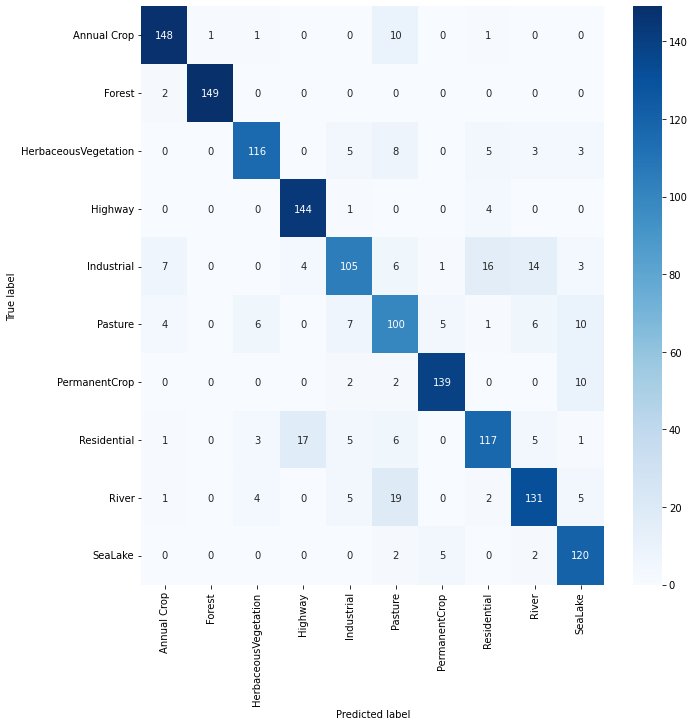

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df,
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()